<a href="https://colab.research.google.com/github/RogerHeederer/NLPwithPyTorch_book/blob/main/SupervisedTraining_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

해당 코드는 Natural Langauage Processing with PyTorch 교재를 보고 참고했습니다.

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

Global Setting

In [143]:
LEFT_CENTER = (3,3)
RIGHT_CENTER = (3,-2)

## 모델 정하기

In [144]:
class Perceptron(nn.Module):
  # 퍼셉트론은 하나의 선형 레이어이다. 즉 Y1 = w1x1+w2x2+....+b, 하나의 수식이라 보면 된다.
  def __init__(self, input_dim): #input_dim은 input data feature의 사이즈이다.
    super(Perceptron, self).__init__()
    self.fc1 = nn.Linear(input_dim, 1)

  def forward(self, x_in): # x_in : input data tensor를 의미하며, x_in.shape은 (batch_size, input_dim)
    return torch.sigmoid(self.fc1(x_in)) # resulting tensor를 의미하고 shpae은 (batch_size, 1)

모델을 정의했으니, 테스트 삼아 하나 만들어보자

In [145]:
model = Perceptron(5) # 퍼셉트론 모델을 만드는데, input dim은 5차원으로 가져가겠다

In [146]:
model

Perceptron(
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

In [147]:
x_data = torch.rand(5)

In [148]:
x_data

tensor([0.2595, 0.7086, 0.5809, 0.0574, 0.7669])

In [149]:
y_data = model(x_data)

In [150]:
y_data

tensor([0.3536], grad_fn=<SigmoidBackward>)

##Get Data Function

랜덤하게 숫자를 뽑아서, 그 숫자가 0.5보다 크면, np.random.normal 함수를 다시 사용.

np.random.normal(loc=(3,3)) : 평균이 (3,3)을 가지고 정규분포를 이룰 수 있는 2차원 난수를 발생시킨다.

In [151]:
test =[]
test.append(np.random.normal(2,5,4))
test

[array([-2.39269447,  5.25961731,  9.60308424,  5.33923393])]

In [152]:
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5: #난수를 생성해서 0.5보다 크면
            x_data.append(np.random.normal(loc=left_center)) # 
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

## 시각화 함수

In [153]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    
    #의사결정선(Decision Boundary, Hyperplane)을 학습시키는 과정을 아래에서 보여줄 것이다.
    #주어진 데이터를 가장 잘 나눌 수 있는 선을 그리는 것이 목표
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

##Data Plot 초기화

In [154]:
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [155]:
x_data, y_truth = get_toy_data(batch_size=1000)

In [156]:
print(x_data.shape, y_truth.shape) 

torch.Size([1000, 2]) torch.Size([1000])


In [157]:
x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy()

In [158]:
x_data.shape, y_truth.shape

((1000, 2), (1000,))

In [159]:
x_data[:10], y_truth[:10]

(array([[ 2.5057817 , -2.7602742 ],
        [ 3.2066646 , -4.011265  ],
        [ 2.7339613 , -2.8999953 ],
        [ 4.4252915 ,  2.720536  ],
        [ 1.9017311 ,  1.183799  ],
        [ 2.3004773 ,  3.5829628 ],
        [ 2.9957101 ,  0.07606971],
        [ 1.6853473 , -2.3796117 ],
        [ 2.591404  ,  3.4314718 ],
        [ 3.1479418 ,  0.2462742 ]], dtype=float32),
 array([1., 1., 1., 0., 0., 0., 1., 1., 0., 0.], dtype=float32))

In [160]:
left_x = []
right_x = []
left_colors = []
right_colors = []

In [161]:
for x_i, y_true_i in zip(x_data, y_truth):
    color = 'black'

    if y_true_i == 0:
        left_x.append(x_i)
        left_colors.append(color)

    else:
        right_x.append(x_i)
        right_colors.append(color)

In [162]:
left_x[:10]

[array([4.4252915, 2.720536 ], dtype=float32),
 array([1.9017311, 1.183799 ], dtype=float32),
 array([2.3004773, 3.5829628], dtype=float32),
 array([2.591404 , 3.4314718], dtype=float32),
 array([3.1479418, 0.2462742], dtype=float32),
 array([2.6893508, 2.0733445], dtype=float32),
 array([4.329008 , 2.0141504], dtype=float32),
 array([2.99161  , 3.4663153], dtype=float32),
 array([3.139889 , 1.2693442], dtype=float32),
 array([2.4140878, 4.156321 ], dtype=float32)]

In [163]:
right_x[:10]

[array([ 2.5057817, -2.7602742], dtype=float32),
 array([ 3.2066646, -4.011265 ], dtype=float32),
 array([ 2.7339613, -2.8999953], dtype=float32),
 array([2.9957101 , 0.07606971], dtype=float32),
 array([ 1.6853473, -2.3796117], dtype=float32),
 array([4.180161  , 0.01642659], dtype=float32),
 array([ 3.757659  , -0.85091794], dtype=float32),
 array([ 3.6416647, -1.7401881], dtype=float32),
 array([ 2.7355573, -1.3818427], dtype=float32),
 array([ 0.53912026, -3.550435  ], dtype=float32)]

In [164]:
#스택 형태로 쌓기
left_x = np.stack(left_x)
right_x = np.stack(right_x)

In [165]:
left_x[:10]

array([[4.4252915, 2.720536 ],
       [1.9017311, 1.183799 ],
       [2.3004773, 3.5829628],
       [2.591404 , 3.4314718],
       [3.1479418, 0.2462742],
       [2.6893508, 2.0733445],
       [4.329008 , 2.0141504],
       [2.99161  , 3.4663153],
       [3.139889 , 1.2693442],
       [2.4140878, 4.156321 ]], dtype=float32)

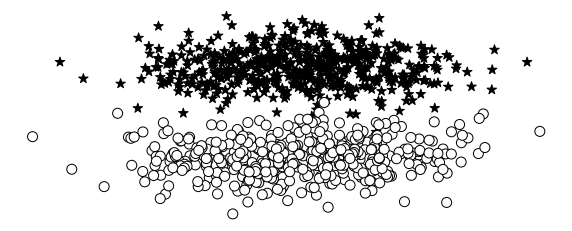

In [166]:
_, ax = plt.subplots(1, 1, figsize=(10,4))
ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker='*', s=100)
ax.scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor=right_colors, marker='o', s=100)
plt.axis('off');

위 그림을 보면, y_true값이 0이냐 1이냐에 따라 나뉘어 분포된 형태를 확인할 수 있다

right_center : 3,-2

left_center : 3,3

위 값을 평균으로 하는 정규분포 난수들을 확인할 수 있다

## Training + data plot

In [167]:
 #우리가 만든 모델이 예측값을 내어 놓으면, loss function은 에러를 측정한다(예측값과 정답 사이에 차이)
 #그럼 optimizer는 그 오류를 활용해서 다음 오류는 작아지는 방향으로 모델의 weights를 업데이트 한다.
 #즉 오류 신호가 가중치 업데이트에 영향을 미친다고 볼 수 있는데, 그 오류 신호를 제어하는 역할이 Learning_rate이다.

#Learning rate - 하이퍼 파라미터의 한 종류
 #Learning rate controls how much impact the error signal has on updating the weights

lr = 0.01
input_dim = 2
batch_size = 1000
n_epochs = 12
n_batches = 5
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

perceptron = Perceptron(input_dim = input_dim)
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = nn.BCELoss() # 클래스 2개 분류하니까 Binary Cross Entropy Loss 사용

losses = []

In [168]:
x_data_static, y_truth_static = get_toy_data(batch_size)

In [169]:
x_data_static.size(), y_truth_static.size()

(torch.Size([1000, 2]), torch.Size([1000]))

(-0.3603001832962036, 6.013579845428467, -5.019380569458008, 5.617672443389893)

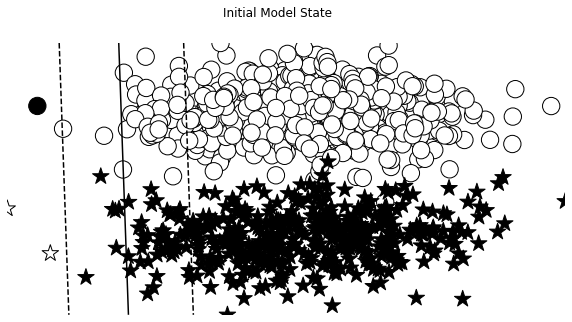

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')

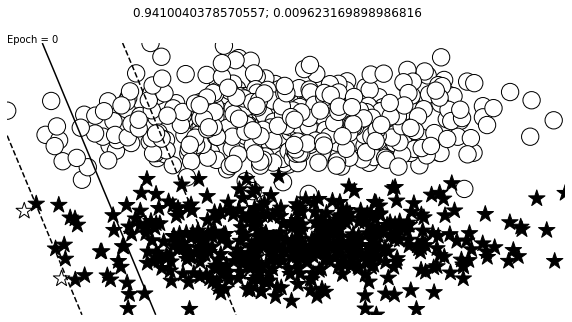

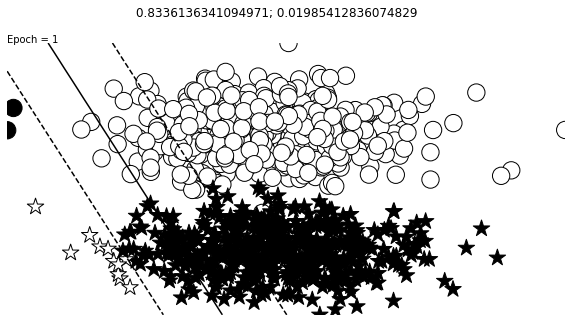

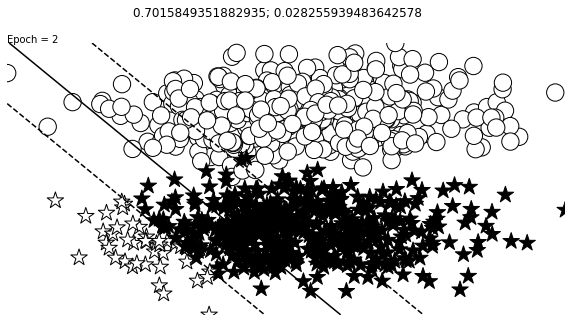

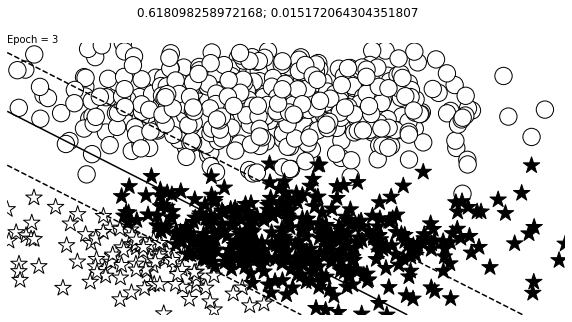

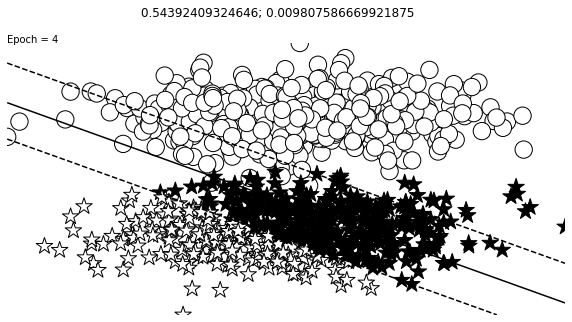

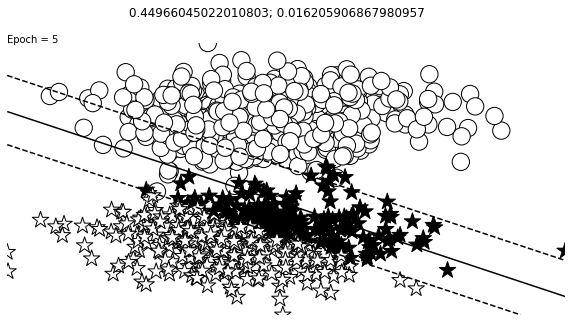

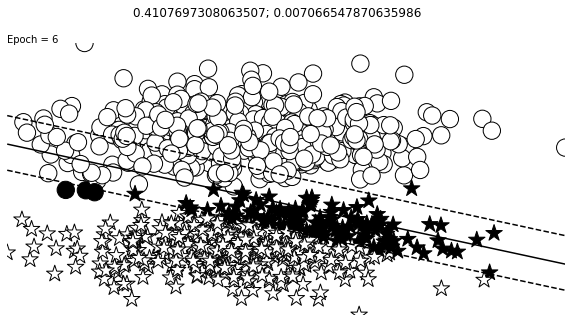

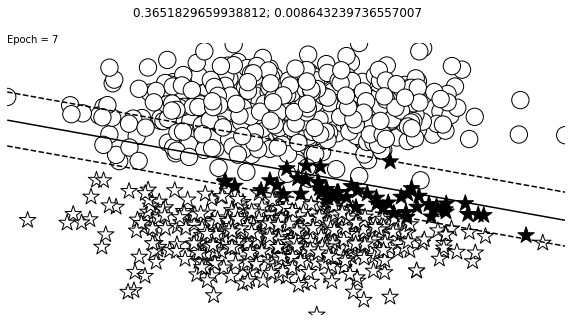

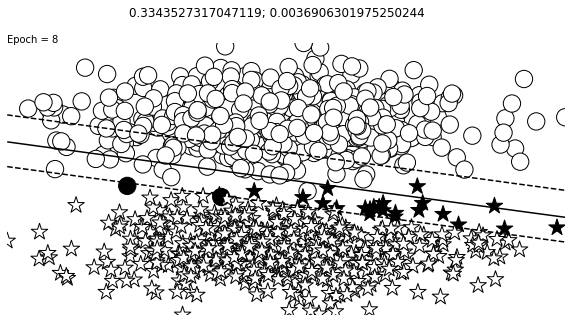

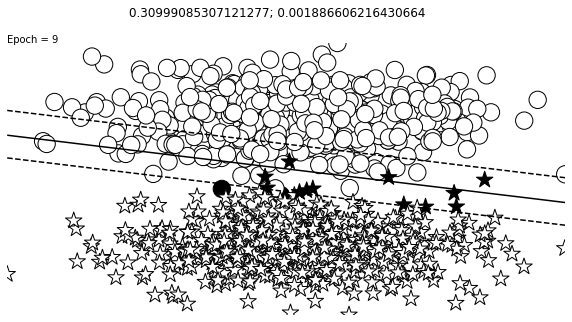

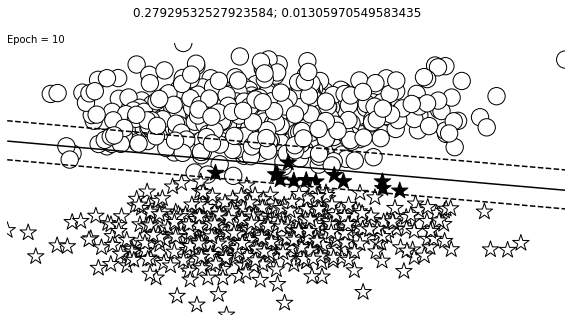

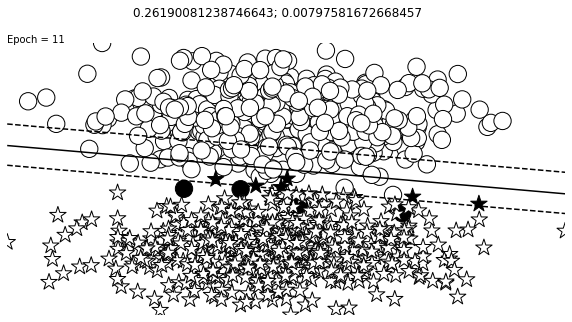

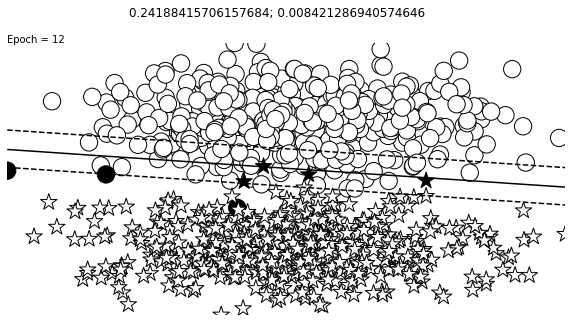

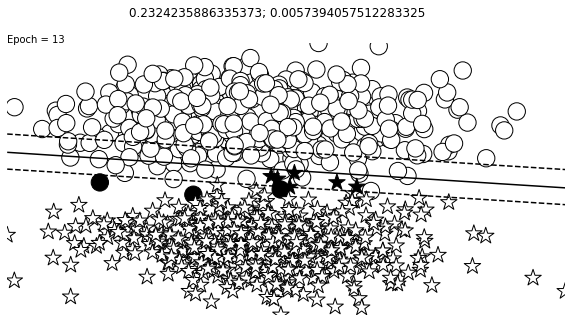

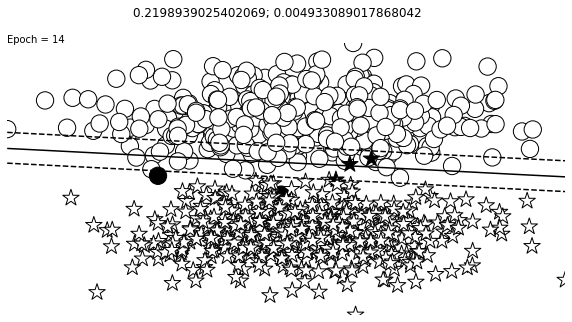

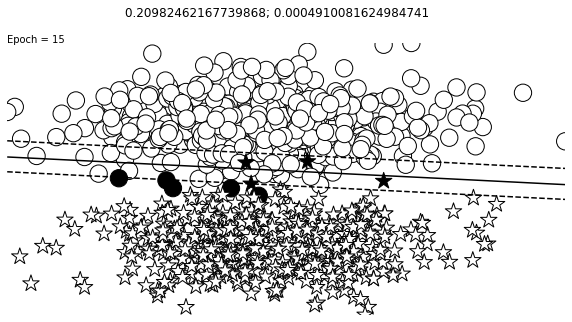

In [171]:
change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0

while change > epsilon or epoch < n_epochs or last > 0.3:
    for _ in range(n_batches):
        optimizer.zero_grad()
        x_data, y_target = get_toy_data(batch_size)
        y_pred = perceptron(x_data).squeeze()
        loss = bce_loss(y_pred, y_target)
        loss.backward() #loss 값을 computational graph를 통해서 back 방향으로 전파한다
        optimizer.step() #파라미터 업데이트

        loss_value = loss.item()
        losses.append(loss_value) #loss 값을 append하여 보관해둔다

        change = abs(last - loss_value)
        last = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(perceptron, x_data, y_target, ax=ax, epoch=epoch,
                      title=f"{loss_value}; {change}")
    plt.axis('off')
    epoch += 1

학습이 거듭될수록 의사결정 선이 자리를 찾아가는 모습을 확인할 수 있다.

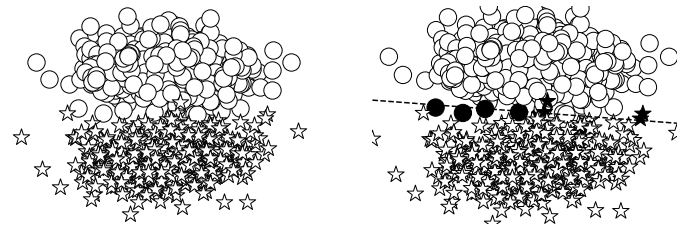

In [172]:
_, axes = plt.subplots(1,2,figsize=(12,4))


axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white',edgecolor='black', marker='o', s=300)
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)
axes[0].axis('off');
visualize_results(perceptron, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
axes[1].axis('off');